In [21]:
# --- Preprocessing ---
import pandas as pd
from sklearn.utils import resample
import numpy as np
from afinn import Afinn
import pickle

# --- Processing ---
import re
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import string
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import collections

# --- Postprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string, collections
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

class Verarbeitung():
    
    def __init__(self,data_here):
        """
            The data is given as a pandas file.
        """
        self.data_here = data_here
        self.my_info_dict = {}
        
        """
            Depending which dataset is used, this
            will load the bert-encoded dataset in 
            order to use it in the bert model. 
        """
        # 
        #with open('bert_emb2_0traintweets.pk', mode='rb') as f:
        with open('Datasets/bert_emb_airline_sentiment.pk', mode='rb') as f:
            self.bert_here = pickle.load(f)

    def auskunft(self):
        """
            --------------
            --- STATUS ---
            --------------
            This function prints relevant information
            related to the data frame which is being
            updated after each preprocessing step. It
            has a dictionary to where the information 
            is added. 
        """
        self.data_length = len(self.data_here)
        self.my_info_dict['Dataset_Length'] = self.data_length
        self.data_column_names = [name for name in (self.data_here).columns]
        self.my_info_dict['Columns'] = self.data_column_names
        return self.my_info_dict
    
    def labels_to_numbers(self,text_field):
        """
            ---------------------
            --- PREPROCESSING ---
            ---------------------

        """
        if text_field in ['sentiment','label','airline_sentiment']:
            label_encoder = LabelEncoder()
            (self.data_here)['target'] = label_encoder.fit_transform((self.data_here)[text_field])
            self.classes = [k for k in label_encoder.classes_]
            self.my_info_dict['Classes'] = self.classes
            self.my_info_dict['Number_of_Classes'] = len(self.classes)
            self.transformed_classes = label_encoder.fit_transform(self.classes)
            self.my_info_dict['Transformed_Classes'] = list(self.transformed_classes)
            #self.classes_and_transformed_classes = dict(zip(self.classes,self.transformed_classes))
        
    def clean_the_tweets(self,text_field):
        """
            ----------------------
            ---- PREPROCESSING ---
            ----------------------
            It cleans the tweets, removing mentions, 
            url's, leaving only characters, deleting
            extra spaces, making every character 
            lower case and adds a column with the 
            name clean_tweet.
        """
        if text_field in ['text','tweet','sentiment','content']:
            (self.data_here)[text_field] = (self.data_here[text_field]).str.lower()
            mystring = r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
            self.data_here['clean_tweet'] = (self.data_here)[text_field].apply(lambda element: re.sub(mystring,"",element))
            self.data_column_names = [name for name in (self.data_here).columns]
            
    def tokens_and_more(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
            It creates tokens, then chooses the frquency of 
            the top fifty of them and displays them in a graph. 
        """
        if text_field in ['sentiment','label','airline_sentiment']:
            cvec = CountVectorizer()
            cvec.fit(self.data_here['clean_tweet'])
            doc_matrices = [cvec.transform(self.data_here[self.data_here[text_field] == k].clean_tweet) for k in self.my_info_dict['Classes']]
            doc_matrices_sums = [np.sum(my_sum,axis=0) for my_sum in doc_matrices]
            all_squeezed = [np.squeeze(np.asarray(k)) for k in doc_matrices_sums]
            term_freq_df = pd.DataFrame(all_squeezed,columns=cvec.get_feature_names()).transpose()
            term_freq_df.columns = self.my_info_dict['Classes']
            term_freq_df['total'] = sum([term_freq_df[k] for k in self.my_info_dict['Classes']])#term_freq_df['positive'] + term_freq_df['neutral'] + term_freq_df['negative']
            term_freq_df.sort_values(by='total', ascending=False)
            print(term_freq_df.sort_values(by='total', ascending=False).head())
            y_neg = np.arange(50)
            for kindex, class_is_here in enumerate(self.my_info_dict['Classes']):
                fig, ax = plt.subplots(figsize=(13,7))
                ax.set_axis_off()
                ax = fig.add_subplot(1,1,1)
                ax.bar(y_neg, term_freq_df.sort_values(by=class_is_here,ascending=False)[class_is_here][:50], align='center',alpha=0.5)
                ax.set_xticks(y_neg)
                ax.set_xticklabels(term_freq_df.sort_values(by=class_is_here,ascending=False)[class_is_here][:50].index,rotation='vertical')
                ax.set_ylabel('Frequency')
                ax.set_xlabel('Top 50 %s tokens'%(self.my_info_dict['Classes'][kindex]))
                ax.set_title('Top 50 tokens in %s tweets'%(self.my_info_dict['Classes'][kindex]))
            plt.show()

    def normalizer(self,text_field):
        """
            ---------------------
            --- PREPROCESSING ---
            ---------------------
            This function removes the stopwords
            and adds the tokens per tweet in a 
            new column. This is part of the 
            preprocessing because this column
            plays an important role as the
            input in the models. 
        """
        re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
        
        def tokenize(s): 
            return re_tok.sub(r' \1 ', s).split()
        
        self.data_here['tokenized'] = self.data_here[text_field].apply(lambda row: tokenize(row))
        stop = set(stopwords.words('english'))
        stop.update(['amp', 'rt', 'cc'])
        stop = stop - set(['no', 'not'])
        
        def remove_stopwords(row):
            return [t for t in row if t not in stop]
        
        self.data_here['tokenized'] = self.data_here['tokenized'].apply(lambda row: remove_stopwords(row))
        
        def update_vocab_counter(row):
            for word in row:
                vocab_counter[word] += 1
                
        vocab_counter = collections.Counter()
        self.data_here['tokenized'].apply(update_vocab_counter)
        vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)
        
        self.my_info_dict['Vocabulary'] = len(vocab)
        max_words = 5000
        self.my_info_dict['Vocabulary_Size_to_Use'] = max_words
        w2id = {w:i+1 for i, w in enumerate(vocab[:max_words-1])}
        w2id['unk'] = 0
        
        self.my_info_dict['Embedding_Dimension_to_Use'] = 50
        
        def transform_to_ids(row):
            return [w2id[w] if w in w2id else w2id['unk'] for w in row]
        
        self.data_here['tokenized_int'] = self.data_here['tokenized'].apply(lambda x: transform_to_ids(x))
        lens = self.data_here['tokenized_int'].apply(lambda x: len(x))
        maxlen = int(np.floor(max(lens)))
        self.my_info_dict['Words_Per_Document'] = maxlen
        
    def prozent_wrt(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
            This function computes the number of sentiments
            in the target column and returns a plot.
        """
        if text_field in ['sentiment','label','airline_sentiment']:
            percentage = (self.data_here).groupby([text_field]).count()
            percentage['clean_tweet'].plot(kind='bar', 
                                           figsize=(8, 6), 
                                           legend=False, 
                                           title='Number of tweets by class')
            plt.show()
       
    def afinn_stuff(self,text_field):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
        """
        af = Afinn()

        # compute sentiment scores (polarity) and labels
        sentiment_scores = [af.score(article) for article in self.data_here['clean_tweet']]
        sentiment_category = ['positive' if score > 0 
                                  else 'negative' if score < 0 
                                      else 'neutral' 
                                          for score in sentiment_scores]

        # sentiment statistics per news category
        if text_field in ['sentiment','label','airline_sentiment']:
            df = pd.DataFrame([list(self.data_here[text_field]), sentiment_scores, sentiment_category]).T
            df.columns = ['sentiment', 'sentiment_score', 'sentiment_category']
            df['sentiment_score'] = df.sentiment_score.astype('float')
            df.groupby(by=['sentiment']).describe()

            f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
            sp = sns.stripplot(x='sentiment', y="sentiment_score",hue='sentiment', data=df, ax=ax1)
            bp = sns.boxplot(x='sentiment', y="sentiment_score", hue='sentiment', data=df, palette="Set2", ax=ax2)
            t = f.suptitle('Visualizing Sentiment', fontsize=14)
            plt.show()
          
    def patterns_of(self,sentiment_field,sentiment):
        """
            ------------------------------
            --- INFORMATION EXTRACTION ---
            ------------------------------
        """
        def ngrams(input_list):
            #onegrams = input_list
            bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
            trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
            return bigrams+trigrams
        self.data_here['grams'] = self.data_here['tokenized'].apply(ngrams)

        def count_words(input):
            cnt = collections.Counter()
            for row in input:
                for word in row:
                    cnt[word] += 1
            return cnt
        
        self.data_here[(self.data_here[sentiment_field] == sentiment)][['grams']].apply(count_words)['grams'].most_common(20)
        return self.data_here[(self.data_here[sentiment_field] == sentiment)][['grams']].apply(count_words)['grams'].most_common(20)
    
    def first_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
            The first model resembles a linear model,
            where just a softmax function is used at 
            the end of the process once we have set
            the variables for the embedding. 
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.data_here['tokenized_int'].values, 
                                                            self.data_here['target'].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        x_train = pad_sequences(X_train, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        x_test = pad_sequences(X_test, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def baseline_model():
            model = Sequential([Embedding(input_dim=self.my_info_dict['Vocabulary_Size_to_Use'], 
                                          output_dim=self.my_info_dict['Embedding_Dimension_to_Use'], 
                                          input_length=self.my_info_dict['Words_Per_Document']),
                                Flatten(),
                                Dense(self.my_info_dict['Number_of_Classes'], activation='softmax')])
            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
            return model
        
        estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, x_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/linear.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = baseline_model()
        model.fit(x_train, dummy_y, validation_data=(x_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        preds = model.predict(x_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))
        
    def bert_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.bert_here, 
                                                            self.data_here['target'].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def baseline_model():
            model = Sequential([
                Dense(100, activation='relu'),
                Dropout(0.5),
                Dense(self.my_info_dict['Number_of_Classes'], activation='softmax'),
            ])
            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
            return model
        
        estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, X_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/bert.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = baseline_model()
        model.fit(X_train, dummy_y, validation_data=(X_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        preds = model.predict(X_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))
        
    def lstm_model(self):
        """
            ------------------
            --- PREDICTION ---
            ------------------
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.data_here['tokenized_int'].values, 
                                                            self.data_here['target'].values, 
                                                            test_size=0.25, 
                                                            random_state=0)
        x_train = pad_sequences(X_train, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        x_test = pad_sequences(X_test, maxlen=self.my_info_dict['Words_Per_Document'], value=0)
        dummy_y = np_utils.to_categorical(y_train)
        dummy_y_test = np_utils.to_categorical(y_test)
        
        def simple_lstm():
            model = Sequential([Embedding(input_dim=self.my_info_dict['Vocabulary_Size_to_Use'], 
                                          output_dim=self.my_info_dict['Embedding_Dimension_to_Use'], 
                                          input_length=self.my_info_dict['Words_Per_Document']),
                                LSTM(25),
                                Dense(self.my_info_dict['Number_of_Classes'], activation='softmax')])

            model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

            return model
        
        estimator = KerasClassifier(build_fn=simple_lstm, epochs=5, batch_size=100, verbose=0)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        results = cross_val_score(estimator, x_train, y_train, cv=kfold)
        print(len(results),' experiments were run: ',[k for k in results])
        PATH = os.getcwd()
        filepath = f'{PATH}/results/lstm.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model = simple_lstm()
        model.fit(x_train, dummy_y, validation_data=(x_test, dummy_y_test), epochs=5, batch_size=100, callbacks=callbacks_list)
        preds = model.predict(x_test)
        print(metrics.classification_report(y_test, np.argmax(preds, axis=1)))


In [22]:
df = pd.read_csv('Datasets/airline_sentiment.csv',encoding='ISO-8859-1')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [23]:
vab = Verarbeitung(df)
vab.auskunft()

{'Dataset_Length': 14640,
 'Columns': ['_unit_id',
  '_golden',
  '_unit_state',
  '_trusted_judgments',
  '_last_judgment_at',
  'airline_sentiment',
  'airline_sentiment:confidence',
  'negativereason',
  'negativereason:confidence',
  'airline',
  'airline_sentiment_gold',
  'name',
  'negativereason_gold',
  'retweet_count',
  'text',
  'tweet_coord',
  'tweet_created',
  'tweet_id',
  'tweet_location',
  'user_timezone']}

In [24]:
vab.labels_to_numbers('airline_sentiment')
vab.auskunft()

{'Dataset_Length': 14640,
 'Columns': ['_unit_id',
  '_golden',
  '_unit_state',
  '_trusted_judgments',
  '_last_judgment_at',
  'airline_sentiment',
  'airline_sentiment:confidence',
  'negativereason',
  'negativereason:confidence',
  'airline',
  'airline_sentiment_gold',
  'name',
  'negativereason_gold',
  'retweet_count',
  'text',
  'tweet_coord',
  'tweet_created',
  'tweet_id',
  'tweet_location',
  'user_timezone',
  'target'],
 'Classes': ['negative', 'neutral', 'positive'],
 'Number_of_Classes': 3,
 'Transformed_Classes': [0, 1, 2]}

In [25]:
vab.clean_the_tweets('text')
vab.auskunft()

{'Dataset_Length': 14640,
 'Columns': ['_unit_id',
  '_golden',
  '_unit_state',
  '_trusted_judgments',
  '_last_judgment_at',
  'airline_sentiment',
  'airline_sentiment:confidence',
  'negativereason',
  'negativereason:confidence',
  'airline',
  'airline_sentiment_gold',
  'name',
  'negativereason_gold',
  'retweet_count',
  'text',
  'tweet_coord',
  'tweet_created',
  'tweet_id',
  'tweet_location',
  'user_timezone',
  'target',
  'clean_tweet'],
 'Classes': ['negative', 'neutral', 'positive'],
 'Number_of_Classes': 3,
 'Transformed_Classes': [0, 1, 2]}

        negative  neutral  positive  total
to      6039      1664     938       8641 
the     4104      973      971       6048 
you     2521      727      860       4108 
for     2707      614      668       3989 
flight  2900      598      373       3871 


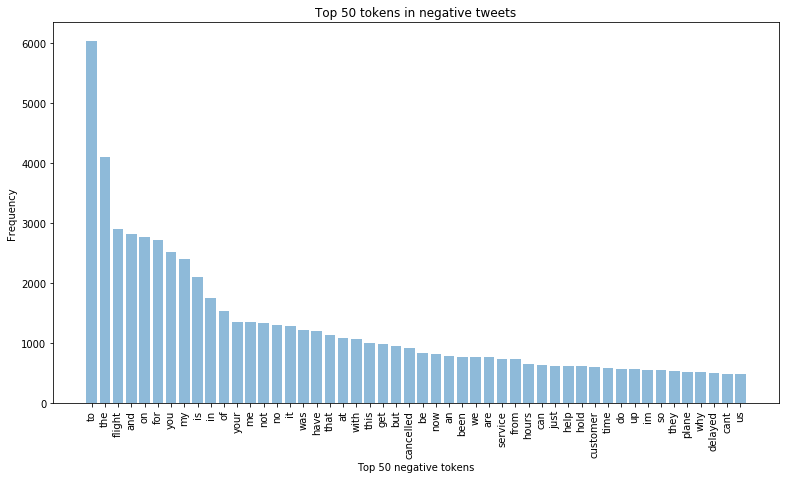

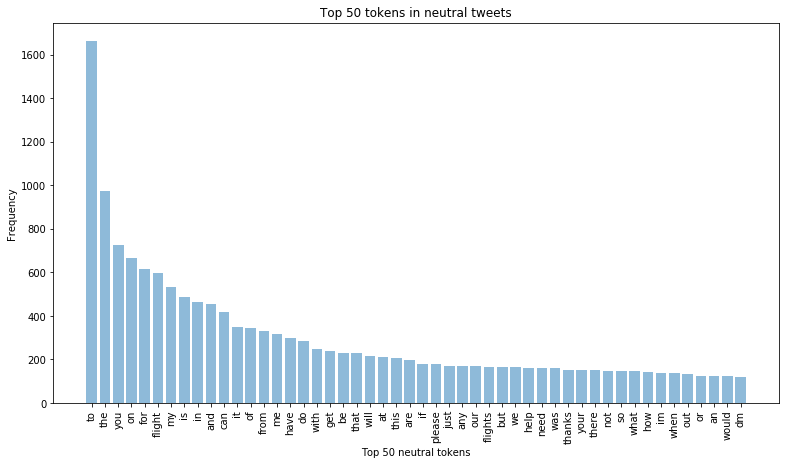

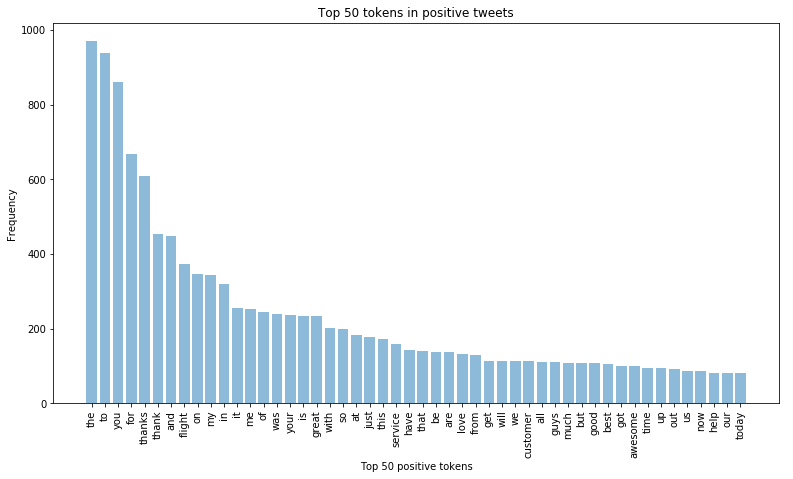

In [26]:
vab.tokens_and_more('airline_sentiment')

In [27]:
vab.normalizer('clean_tweet')
vab.auskunft()

{'Dataset_Length': 14640,
 'Columns': ['_unit_id',
  '_golden',
  '_unit_state',
  '_trusted_judgments',
  '_last_judgment_at',
  'airline_sentiment',
  'airline_sentiment:confidence',
  'negativereason',
  'negativereason:confidence',
  'airline',
  'airline_sentiment_gold',
  'name',
  'negativereason_gold',
  'retweet_count',
  'text',
  'tweet_coord',
  'tweet_created',
  'tweet_id',
  'tweet_location',
  'user_timezone',
  'target',
  'clean_tweet',
  'tokenized',
  'tokenized_int'],
 'Classes': ['negative', 'neutral', 'positive'],
 'Number_of_Classes': 3,
 'Transformed_Classes': [0, 1, 2],
 'Vocabulary': 14648,
 'Vocabulary_Size_to_Use': 5000,
 'Embedding_Dimension_to_Use': 50,
 'Words_Per_Document': 23}

In [28]:
vab.data_here.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,...,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,target,clean_tweet,tokenized,tokenized_int
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,...,@virginamerica what @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada),1,what said,[said],[132]
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,...,@virginamerica plus you've added commercials to the experience... tacky.,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),2,plus youve added commercials to the experience tacky,"[plus, youve, added, commercials, experience, tacky]","[434, 435, 1007, 2312, 114, 0]"
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,...,@virginamerica i didn't today... must mean i need to take another trip!,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada),1,i didnt today must mean i need to take another trip,"[didnt, today, must, mean, need, take, another, trip]","[107, 37, 663, 455, 23, 75, 70, 111]"
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,...,"@virginamerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),0,its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse,"[really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]","[61, 3490, 4394, 4395, 866, 2930, 3491, 385, 2566]"
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,...,@virginamerica and it's a really big bad thing about it,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada),0,and its a really big bad thing about it,"[really, big, bad, thing]","[61, 369, 123, 386]"


In [43]:
vab.data_here['text'].head()

0    @virginamerica what @dhepburn said.                                                                                           
1    @virginamerica plus you've added commercials to the experience... tacky.                                                      
2    @virginamerica i didn't today... must mean i need to take another trip!                                                       
3    @virginamerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4    @virginamerica and it's a really big bad thing about it                                                                       
Name: text, dtype: object

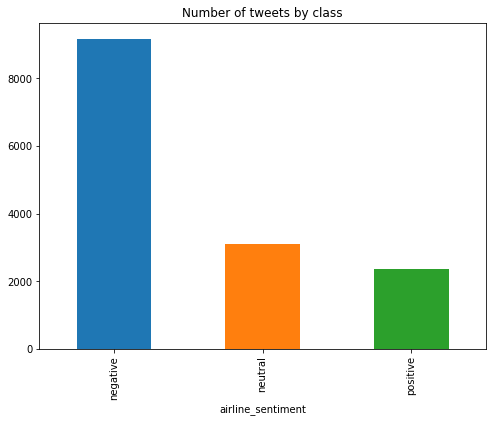

In [29]:
vab.prozent_wrt('airline_sentiment')

In [30]:
vab.auskunft()

{'Dataset_Length': 14640,
 'Columns': ['_unit_id',
  '_golden',
  '_unit_state',
  '_trusted_judgments',
  '_last_judgment_at',
  'airline_sentiment',
  'airline_sentiment:confidence',
  'negativereason',
  'negativereason:confidence',
  'airline',
  'airline_sentiment_gold',
  'name',
  'negativereason_gold',
  'retweet_count',
  'text',
  'tweet_coord',
  'tweet_created',
  'tweet_id',
  'tweet_location',
  'user_timezone',
  'target',
  'clean_tweet',
  'tokenized',
  'tokenized_int'],
 'Classes': ['negative', 'neutral', 'positive'],
 'Number_of_Classes': 3,
 'Transformed_Classes': [0, 1, 2],
 'Vocabulary': 14648,
 'Vocabulary_Size_to_Use': 5000,
 'Embedding_Dimension_to_Use': 50,
 'Words_Per_Document': 23}

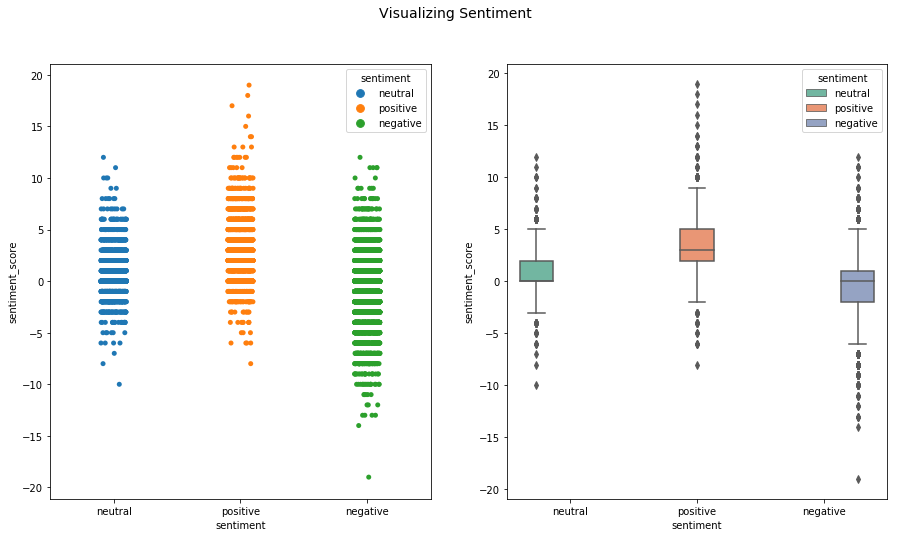

In [31]:
vab.afinn_stuff('airline_sentiment')

In [32]:
vab.auskunft()

{'Dataset_Length': 14640,
 'Columns': ['_unit_id',
  '_golden',
  '_unit_state',
  '_trusted_judgments',
  '_last_judgment_at',
  'airline_sentiment',
  'airline_sentiment:confidence',
  'negativereason',
  'negativereason:confidence',
  'airline',
  'airline_sentiment_gold',
  'name',
  'negativereason_gold',
  'retweet_count',
  'text',
  'tweet_coord',
  'tweet_created',
  'tweet_id',
  'tweet_location',
  'user_timezone',
  'target',
  'clean_tweet',
  'tokenized',
  'tokenized_int'],
 'Classes': ['negative', 'neutral', 'positive'],
 'Number_of_Classes': 3,
 'Transformed_Classes': [0, 1, 2],
 'Vocabulary': 14648,
 'Vocabulary_Size_to_Use': 5000,
 'Embedding_Dimension_to_Use': 50,
 'Words_Per_Document': 23}

In [33]:
vab.patterns_of('airline_sentiment','neutral')

[('fleets fleek', 102),
 ('cancelled flightled', 48),
 ('booking problems', 36),
 ('flight booking', 29),
 ('flight booking problems', 29),
 ('please help', 23),
 ('passengers wall', 21),
 ('customer service', 20),
 ('would love', 20),
 ('wall street', 17),
 ('cancelled flighted', 16),
 ('late flight', 16),
 ('first class', 15),
 ('way get', 15),
 ('follow dm', 15),
 ('appease passengers', 15),
 ('us airways', 15),
 ('email address', 14),
 ('confirmation number', 14),
 ('tomorrow morning', 14)]

In [34]:
vab.patterns_of('airline_sentiment','negative')

[('customer service', 444),
 ('cancelled flightled', 438),
 ('late flight', 219),
 ('cancelled flighted', 197),
 ('flight cancelled', 185),
 ('late flightr', 142),
 ('2 hours', 123),
 ('cancelled flight', 122),
 ('no one', 120),
 ('flight cancelled flightled', 118),
 ('cant get', 106),
 ('booking problems', 97),
 ('call back', 97),
 ('flightled flight', 91),
 ('cancelled flightled flight', 91),
 ('flight delayed', 88),
 ('3 hours', 68),
 ('still no', 64),
 ('gate agent', 62),
 ('please help', 60)]

In [35]:
vab.patterns_of('airline_sentiment','positive')

[('customer service', 91),
 ('thank much', 36),
 ('thanks much', 29),
 ('great flight', 27),
 ('great job', 22),
 ('thanks help', 21),
 ('flight attendant', 20),
 ('cant wait', 20),
 ('no worries', 19),
 ('looking forward', 18),
 ('quick response', 16),
 ('great service', 16),
 ('best airline', 15),
 ('good work', 15),
 ('great customer', 14),
 ('great customer service', 14),
 ('fleets fleek', 14),
 ('guys rock', 13),
 ('thanks reply', 13),
 ('thanks great', 12)]

In [36]:
vab.data_here.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,...,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,target,clean_tweet,tokenized,tokenized_int,grams
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,...,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada),1,what said,[said],[132],[]
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),2,plus youve added commercials to the experience tacky,"[plus, youve, added, commercials, experience, tacky]","[434, 435, 1007, 2312, 114, 0]","[plus youve, youve added, added commercials, commercials experience, experience tacky, plus youve added, youve added commercials, added commercials experience, commercials experience tacky]"
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada),1,i didnt today must mean i need to take another trip,"[didnt, today, must, mean, need, take, another, trip]","[107, 37, 663, 455, 23, 75, 70, 111]","[didnt today, today must, must mean, mean need, need take, take another, another trip, didnt today must, today must mean, must mean need, mean need take, need take another, take another trip]"
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),0,its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse,"[really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]","[61, 3490, 4394, 4395, 866, 2930, 3491, 385, 2566]","[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guests, guests faces, faces little, little recourse, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guests, entertainment guests faces, guests faces little, faces little recourse]"
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada),0,and its a really big bad thing about it,"[really, big, bad, thing]","[61, 369, 123, 386]","[really big, big bad, bad thing, really big bad, big bad thing]"


In [37]:
vab.bert_model()

5  experiments were run:  [0.8066424016956854, 0.8170232114652964, 0.8059225484287549, 0.8068337156723735, 0.8232346193393977]
Train on 10980 samples, validate on 3660 samples
Epoch 1/5
10980/10980 [==============================] - 2s 153us/step - loss: 0.6661 - acc: 0.7322 - val_loss: 0.5256 - val_acc: 0.7910

Epoch 00001: val_acc improved from -inf to 0.79098, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/bert.hdf5
Epoch 2/5
10980/10980 [==============================] - 0s 26us/step - loss: 0.5147 - acc: 0.7965 - val_loss: 0.5066 - val_acc: 0.8005

Epoch 00002: val_acc improved from 0.79098 to 0.80055, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/bert.hdf5
Epoch 3/5
10980/10980 [==============================] - 0s 27us/step - loss: 0.4852 - acc: 0.8081 - val_loss: 0.4946 - val_acc: 0.8000

Epoch 00003: val_acc did not improve from 0.80055
Epoch 4/5
10980/10980 [==============================] - 0s 26us/step - loss: 0.4710 - acc: 0

In [38]:
vab.first_model()

5  experiments were run:  [0.8043676021426672, 0.7892580724435336, 0.7922551253118928, 0.7881548960007948, 0.789977214466738]
Train on 10980 samples, validate on 3660 samples
Epoch 1/5
10980/10980 [==============================] - 2s 166us/step - loss: 0.8686 - acc: 0.6303 - val_loss: 0.7569 - val_acc: 0.6604

Epoch 00001: val_acc improved from -inf to 0.66038, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/linear.hdf5
Epoch 2/5
10980/10980 [==============================] - 0s 31us/step - loss: 0.6404 - acc: 0.7387 - val_loss: 0.6139 - val_acc: 0.7486

Epoch 00002: val_acc improved from 0.66038 to 0.74863, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/linear.hdf5
Epoch 3/5
10980/10980 [==============================] - 0s 31us/step - loss: 0.4820 - acc: 0.8234 - val_loss: 0.5524 - val_acc: 0.7817

Epoch 00003: val_acc improved from 0.74863 to 0.78169, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/linear.hdf5
Ep

In [39]:
vab.data_here.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,...,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,target,clean_tweet,tokenized,tokenized_int,grams
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,...,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada),1,what said,[said],[132],[]
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),2,plus youve added commercials to the experience tacky,"[plus, youve, added, commercials, experience, tacky]","[434, 435, 1007, 2312, 114, 0]","[plus youve, youve added, added commercials, commercials experience, experience tacky, plus youve added, youve added commercials, added commercials experience, commercials experience tacky]"
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada),1,i didnt today must mean i need to take another trip,"[didnt, today, must, mean, need, take, another, trip]","[107, 37, 663, 455, 23, 75, 70, 111]","[didnt today, today must, must mean, mean need, need take, take another, another trip, didnt today must, today must mean, must mean need, mean need take, need take another, take another trip]"
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),0,its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse,"[really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]","[61, 3490, 4394, 4395, 866, 2930, 3491, 385, 2566]","[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guests, guests faces, faces little, little recourse, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guests, entertainment guests faces, guests faces little, faces little recourse]"
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada),0,and its a really big bad thing about it,"[really, big, bad, thing]","[61, 369, 123, 386]","[really big, big bad, bad thing, really big bad, big bad thing]"


In [40]:
vab.lstm_model()

5  experiments were run:  [0.8030027270967902, 0.7874374083079259, 0.7831435075924988, 0.7717539898898444, 0.7822323425212591]
Train on 10980 samples, validate on 3660 samples
Epoch 1/5
10980/10980 [==============================] - 5s 482us/step - loss: 0.8223 - acc: 0.6629 - val_loss: 0.6629 - val_acc: 0.7257

Epoch 00001: val_acc improved from -inf to 0.72568, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/lstm.hdf5
Epoch 2/5
10980/10980 [==============================] - 2s 220us/step - loss: 0.5514 - acc: 0.7884 - val_loss: 0.5750 - val_acc: 0.7798

Epoch 00002: val_acc improved from 0.72568 to 0.77978, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/lstm.hdf5
Epoch 3/5
10980/10980 [==============================] - 2s 219us/step - loss: 0.4245 - acc: 0.8363 - val_loss: 0.5530 - val_acc: 0.7811

Epoch 00003: val_acc improved from 0.77978 to 0.78115, saving model to /Users/id/Dropbox/DS/2Entscheidung/AML/Project/results/lstm.hdf5
Epoch